In [11]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random

In [12]:
from pyomo.environ import *
from numpy import flatnonzero as find
from pypower.api import case9, ext2int, bustypes, makeBdc, rundcpf, ppoption
from pypower.idx_bus import BUS_TYPE, REF, VA, PD, LAM_P, LAM_Q, MU_VMAX, MU_VMIN
from pypower.idx_gen import PG, MU_PMAX, MU_PMIN, MU_QMAX, MU_QMIN, PMAX, PMIN, GEN_BUS
from pypower.idx_brch import PF, PT, QF, QT, RATE_A, MU_SF, MU_ST
from pypower.idx_cost import COST
import matplotlib.pyplot as plt

In [13]:
# Run PyPower case to get initial condition
ppc = case9()
ppopt = ppoption(VERBOSE=0)
pp_dcpf, success = rundcpf(ppc, ppopt)
pp_bus = pp_dcpf["bus"]
pp_branch = pp_dcpf["branch"]
pp_gen = pp_dcpf["gen"]


Converged in 0.00 seconds
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0           0.0 to 0.0
Generators         3     On-line Capacity       820.0           0.0 to 0.0
Committed Gens     3     Generation (actual)    314.0               0.0
Loads              3     Load                   315.0               0.0
  Fixed            3       Fixed                315.0               0.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           9     Losses (I^2 * Z)         0.00              0.00
Transformers       0     Branch Charging (inj)     -                0.0
Inter-ties         0     Total Inter-tie Flow     0.0               0.0
Areas     

In [14]:
## convert to internal indexing
ppc = ext2int(ppc)
baseMVA, bus, gen, branch, gencost = \
    ppc["baseMVA"], ppc["bus"], ppc["gen"], ppc["branch"], ppc["gencost"]

## get bus index lists of each type of bus
ref, pv, pq = bustypes(bus, gen)
pvpq = np.matrix(np.r_[pv, pq])

## generator info
gbus = gen[:, GEN_BUS].astype(int)    ## what buses are they at?
refgen = find(gbus == ref)

## build B matrices and phase shift injections
B, Bf, _, _ = makeBdc(baseMVA, bus, branch)
B = B.todense()
Bf = Bf.todense()

# Problem dimensions
NG = gen.shape[0] # Number of generators
NB = bus.shape[0] # Number of buses
NBr = branch.shape[0] # Number of lines
NL = 3 # Number of loads
NW = 1 # Number of wind farms

# Map generator to bus
CG = np.zeros((NB,NG))
CG[gbus,range(3)] = 1

# Map load to bus
CL = np.zeros((NB,NL))
CL[4,0] = 1
CL[6,1] = 1
CL[8,2] = 1

# Map wind farm to bus
CW = np.zeros((NB,1))
CW[5,0] = 1

# Generator capacity limit p.u.
Pmax = gen[:, PMAX]/baseMVA
Pmin = gen[:, PMIN]/baseMVA

# Line flow limit p.u.
Lmax = branch[:, RATE_A]/baseMVA
Lmin = - branch[:, RATE_A]/baseMVA

# Quadratic cost coefficients
# Convert to p.u.
CG2 = gencost[:, COST]*baseMVA**2
CG1 = gencost[:, COST+1]*baseMVA
CG0 = gencost[:, COST+2]

# Cost coefficient for wind power
CW1 = 0
CW0 = 0

# Cost coefficients for generation reserve
CRG_up = 10*np.ones((NG,1))*baseMVA
CRG_down = 10*np.ones((NG,1))*baseMVA

# Cost coefficients for load reserve
CRL_up = 9.8*np.ones((NL,1))*baseMVA
CRL_down = 9.8*np.ones((NL,1))*baseMVA

# Uncontrollable load
PL_total = np.array([90,100,125])
PL = PL_total/baseMVA

# Generator and demand set points
# Power in p.u., Va in rad
Pg0 = pp_gen[:, PG]/baseMVA
Pd0 = pp_bus[:, PD]/baseMVA
Pinj0 = (np.matmul(CG, Pg0) - Pd0)
Va0 = pp_bus[:, VA]/180*np.pi

In [15]:
# Read temperature data
weather_data = pd.read_csv("Weather_Data/NYC_Hourly_Normal_Temp.csv")
# Read wind power data
PW_data = pd.read_csv("spring_wind.csv",header=None).to_numpy()
PW_data = PW_data/500*20/baseMVA

In [16]:
Tamb = (weather_data.iloc[:,8] - 32)/1.8
Tamb_min = min(Tamb)
Tamb_10PCTL = (weather_data.iloc[:,6] - 32)/1.8
Tamb_90PCTL = (weather_data.iloc[:,7] - 32)/1.8
std_Tamb_10PCTL = (Tamb - Tamb_10PCTL)/1.282 
std_Tamb_90PCTL = (Tamb_90PCTL - Tamb)/1.282 
std_Tamb = (std_Tamb_10PCTL + std_Tamb_90PCTL)/10

In [17]:
def VS(dt,Tamb,num_TCL,Tset,delta,R,C,P_el,COP,baseMVA):
    Tdown = np.zeros(num_TCL)
    Tup = np.zeros(num_TCL)
    T_ON = np.zeros(num_TCL)
    T_OFF = np.zeros(num_TCL)
    D = np.zeros(num_TCL)
    B = 0
    Pdown = 0
    Pup = 0
    Sdown = 0
    Sup = 0
    for i in range(0,num_TCL):
        Tdown[i] = Tset[i] - delta/2
        Tup[i] = Tset[i] + delta/2
        T_ON[i] = C[i]*R[i]*np.log((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]))
        if ((Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])/(Tup[i] - Tamb - R[i]*P_el[i]*COP[i]) < 0):
            print(Tdown[i] - Tamb - R[i]*P_el[i]*COP[i])
            print(Tup[i] - Tamb - R[i]*P_el[i]*COP[i])
        T_OFF[i] = C[i]*R[i]*np.log((Tup[i] - Tamb)/(Tdown[i] - Tamb))
        D[i] = T_ON[i]/(T_ON[i] + T_OFF[i])
        if ( Tamb < Tdown[i] and Tamb + R[i]*P_el[i]*COP[i] > Tup[i] ):
            B = B + P_el[i]*D[i]
            Pup = Pup + P_el[i]
            Sup = Sup + dt*P_el[i]*(1 - D[i])
    return [B/1000/baseMVA,Pdown/1000/baseMVA,Pup/1000/baseMVA,Sdown,Sup]

In [18]:
# Parameters related to the demand side
num_TCL = 5000
Tset = np.zeros((num_TCL,NL))
R = np.zeros((num_TCL,NL))
C = np.zeros((num_TCL,NL))
COP = np.zeros((num_TCL,NL))
P_el = np.zeros((num_TCL,NL))
Tset_set = [21,21.5,22,22.5,23]
for i in range(num_TCL): 
    for j in range(NL):
        s = random.sample(Tset_set,1)
        Tset[i,j] = s[0] 
delta = 1
R_nom = 2
R_low = 0.8*R_nom
R_high = 1.2*R_nom
C_nom = 2
C_low = 0.8*C_nom
C_high = 1.2*C_nom
COP_nom = 2.5
COP_low = 0.8*COP_nom
COP_high = 1.2*COP_nom
for i in range(NL): 
    R[:,i] = np.random.uniform(R_low,R_high,num_TCL)
    C[:,i] = np.random.uniform(C_low,C_high,num_TCL)
    COP[:,i] = np.random.uniform(COP_low,COP_high,num_TCL)
    for j in range(num_TCL):
        P_el[j,i] = np.ceil((Tset[j,i] + delta/2 - Tamb_min)/(R[j,i]*COP[j,i])) + 3
# Sampling
eps = 0.1
beta = 0.1
num_decision_variables = 5*NG + 5*NL
num_samples = np.ceil((2/eps)*(np.log(1/beta) + num_decision_variables)).astype(int)
num_samples2 = np.ceil((num_decision_variables + 1 + np.log(1/beta) + np.sqrt(2*(num_decision_variables+1)*np.log(1/beta)))/eps).astype(int)

# np.random.seed(1)
# Tamb_sample = np.random.normal(mu_Tamb,sigma_Tamb,num_samples)
# PW_sample = np.random.choice(PW_data[i,:], size=num_samples)

P_B = np.zeros((NL,1))
Pdown = np.zeros((NL,1))
Pup = np.zeros((NL,1))
Sdown = np.zeros((NL,1))
Sup = np.zeros((NL,1))
S0 = np.zeros((NL,1))

for j in range(NL):
    [P_B[j],Pdown[j],Pup[j],Sdown[j],Sup[j]] = \
        VS(0.25,Tamb[0],num_TCL,Tset[:,j],delta,R[:,j],C[:,j],P_el[:,j],COP[:,j],baseMVA)
    S0[j] = (Sdown[j] + Sup[j])/2    

In [19]:
file = open("Results/models_453", "rb")
models = pickle.load(file)
file.close()

In [20]:
def cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL):
    r_pg = np.zeros(NG)
    r_rg_up = np.zeros(NG)
    r_rg_down = np.zeros(NG)
    r_rl_up = np.zeros(NL)
    r_rl_down = np.zeros(NL)
    r_pc = np.zeros(NL)
    gen_cost = np.zeros(NG)
    gen_r_cost = np.zeros(NG)
    load_r_cost = np.zeros(NL)


    for i in range(NG):
        r_pg[i] = model.PG[i]()
        r_rg_up[i] = model.RG_up[i]()
        r_rg_down[i] = model.RG_down[i]()
        gen_cost[i] = CG0[i] + CG1[i]*r_pg[i] + CG2[i]*r_pg[i]**2
        gen_r_cost[i] = CRG_up[i]*r_rg_up[i] + CRG_down[i]*r_rg_down[i]

    for i in range(NL):
        r_rl_up[i] = model.RL_up[i]()
        r_rl_down[i] = model.RL_down[i]()
        r_pc[i] = model.PC[i]()
        load_r_cost[i] = CRL_up[i]*r_rl_up[i] + CRL_down[i]*r_rl_down[i]

    total_cost = np.sum(gen_cost + gen_r_cost) + np.sum(load_r_cost)

    return gen_cost,gen_r_cost,load_r_cost,total_cost

In [21]:
nsample = 453
nhours = 24

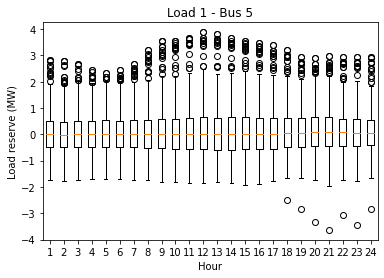

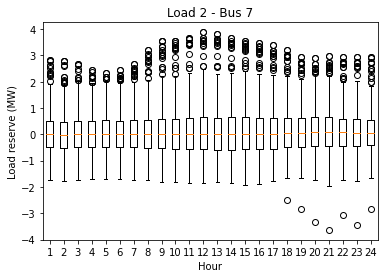

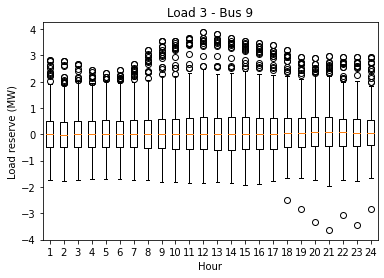

In [22]:
# Read RL data
RL_all_hour = np.zeros((NL, nhours, nsample))

for h in range(nhours):
    model = models[h]
    RL_all = model.RL[:,:]()
    RL_all = np.array(RL_all).reshape(NL, nsample)*baseMVA

    for i in range(NL):
        RL_one = RL_all[i, :]
        RL_all_hour[i, h, :] = RL_one

# RL boxplot
load_bus = [5, 7, 9]

for i in range(NL):
    fig = plt.figure()
    RL_plot = RL_all_hour[i, :, :].tolist()
    plt.boxplot(RL_plot)
    plt.title("Load %d - Bus %d" %((i+1), load_bus[i]))
    plt.xlabel("Hour")
    plt.ylabel("Load reserve (MW)")
    plt.show()

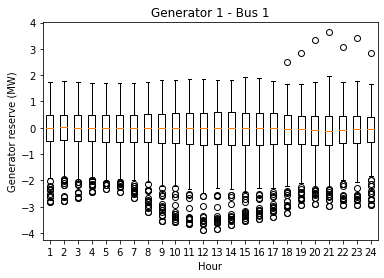

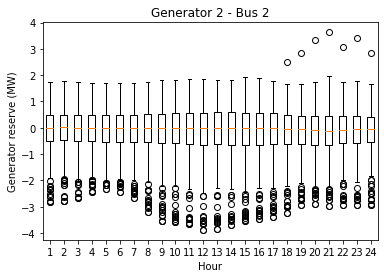

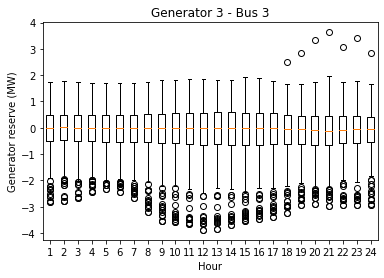

In [23]:
# Read RG data
RG_all_hour = np.zeros((NG, nhours, nsample))

for h in range(nhours):
    model = models[h]
    RG_all = model.RG[:,:]()
    RG_all = np.array(RG_all).reshape(NG, nsample)*baseMVA

    for i in range(NG):
        RG_one = RG_all[i, :]
        RG_all_hour[i, h, :] = RG_one

# RG boxplot
gen_bus = [1, 2, 3]

for i in range(NG):
    fig = plt.figure()
    RG_plot = RG_all_hour[i, :, :].tolist()
    plt.boxplot(RG_plot)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]))
    plt.xlabel("Hour")
    plt.ylabel("Generator reserve (MW)")
    plt.show()

Generator:  0
RG up:  [1.74411264 1.79067584 1.75109199 1.68898725 1.68887963 1.70483323
 1.72047457 1.74184835 1.81852838 1.82078003 1.85101023 1.86297567
 1.82650801 1.8359934  1.94157841 1.89006212 1.76010986 2.5061428
 2.8425301  3.34023053 3.63192505 3.07107267 3.42936127 2.82884585]
RG down:  [2.8165888  2.79525776 2.66150325 2.4281787  2.32245197 2.45328095
 2.66855822 3.19311464 3.54567809 3.56146155 3.65923    3.88036894
 3.82696321 3.67561004 3.54381354 3.45340817 3.38810071 3.22353322
 2.92973996 2.88412076 2.95921525 2.93688484 2.92517866 2.92515886]
Generator:  1
RG up:  [1.74411263 1.79067585 1.75109199 1.68898728 1.68887984 1.70483372
 1.72047457 1.74184835 1.81852838 1.82077981 1.85101015 1.86297567
 1.82651036 1.83599331 1.9415787  1.89006212 1.76011016 2.5061428
 2.8425301  3.34023053 3.63192505 3.07107267 3.42936127 2.82884584]
RG down:  [2.81658882 2.79525761 2.66150325 2.42817877 2.32245327 2.45327906
 2.66855822 3.19311463 3.54567809 3.56146191 3.6592302  3.880368

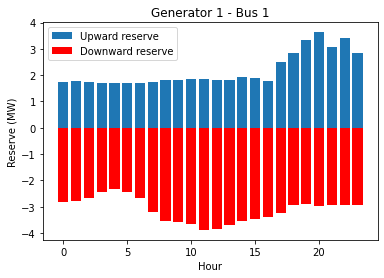

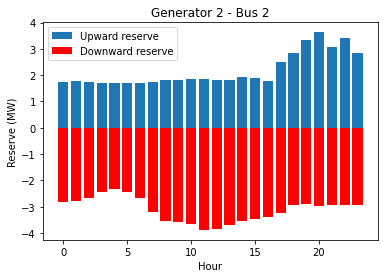

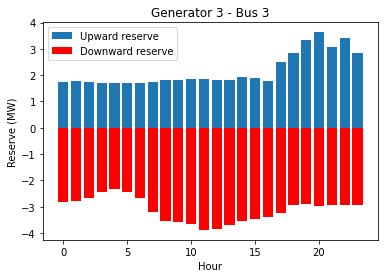

In [24]:
# Read RG up and down data
RG_up_all_hour = np.zeros((NG, nhours))
RG_down_all_hour = np.zeros((NG, nhours))

for h in range(nhours):
    model = models[h]
    RG_up_all = model.RG_up[:]()
    RG_down_all = model.RG_down[:]()
    RG_up_all = np.array(RG_up_all).reshape(NG)*baseMVA
    RG_down_all = np.array(RG_down_all).reshape(NG)*baseMVA

    for i in range(NG):
        RG_up_one = RG_up_all[i]
        RG_down_one = RG_down_all[i]
        RG_up_all_hour[i, h] = RG_up_one
        RG_down_all_hour[i, h] = RG_down_one

# Plot RG up and down data
for i in range(NG):
    print("Generator: ", i)
    fig = plt.figure()

    RG_up_plot = RG_up_all_hour[i, :]
    print("RG up: ", RG_up_plot)
    plt.bar(range(nhours),RG_up_plot, label="Upward reserve")

    RG_down_plot = RG_down_all_hour[i, :]
    print("RG down: ", RG_down_plot)
    plt.bar(range(nhours),-RG_down_plot, color='r', label="Downward reserve")

    plt.legend()
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]))
    plt.xlabel("Hour")
    plt.ylabel("Reserve (MW)")

Load:  0
RL up:  [2.81659039 2.79527279 2.66150368 2.42817916 2.32245228 2.4532796
 2.66855857 3.19311508 3.54567854 3.56146368 3.65923077 3.88036936
 3.82696352 3.67560995 3.54381432 3.45340857 3.3881011  3.22345155
 2.92963741 2.88379631 2.95873312 2.93664497 2.92488832 2.9249388 ]
RL down:  [1.74411187 1.79067115 1.75109213 1.68898739 1.68887983 1.70483445
 1.72047475 1.74184848 1.8185285  1.82077916 1.85101025 1.86297593
 1.82650893 1.83599228 1.94157842 1.89006226 1.76011003 2.50626388
 2.84269768 3.34080968 3.63282556 3.07142995 3.42982993 2.82914663]
Load:  1
RL up:  [2.81659159 2.79527272 2.66150366 2.42817916 2.32245214 2.45328205
 2.66855859 3.19311508 3.54567854 3.56146368 3.65923083 3.88036936
 3.82696356 3.67560984 3.54381451 3.45340857 3.3881011  3.22345155
 2.92963746 2.88402285 2.95906448 2.93665946 2.92489696 2.92490495]
RL down:  [1.74411412 1.79067118 1.75109213 1.68898743 1.68887995 1.70483337
 1.72047473 1.74184849 1.8185285  1.82077916 1.85101022 1.86297592
 1.826

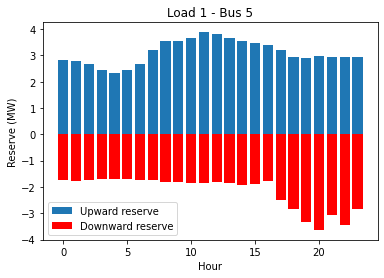

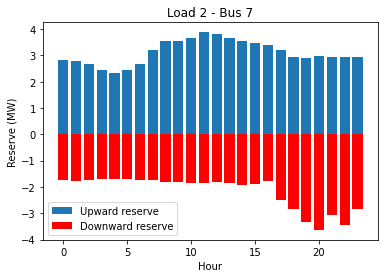

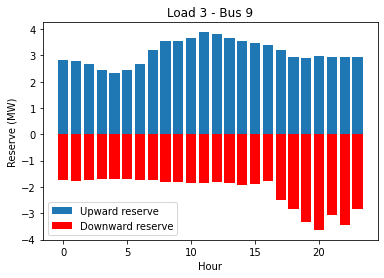

In [25]:
# Read RL up and down data
RL_up_all_hour = np.zeros((NL, nhours))
RL_down_all_hour = np.zeros((NL, nhours))

for h in range(nhours):
    model = models[h]
    RL_up_all = model.RL_up[:]()
    RL_down_all = model.RL_down[:]()
    RL_up_all = np.array(RL_up_all).reshape(NL)*baseMVA
    RL_down_all = np.array(RL_down_all).reshape(NL)*baseMVA

    for i in range(NL):
        RL_up_one = RL_up_all[i]
        RL_down_one = RL_down_all[i]
        RL_up_all_hour[i, h] = RL_up_one
        RL_down_all_hour[i, h] = RL_down_one

# Plot RG up and down data
for i in range(NL):

    print("Load: ", i)
    fig = plt.figure()

    RL_up_plot = RL_up_all_hour[i, :]
    print("RL up: ", RL_up_plot)
    plt.bar(range(nhours),RL_up_plot, label="Upward reserve")

    RL_down_plot = RL_down_all_hour[i, :]
    print("RL down: ", RL_down_plot)
    plt.bar(range(nhours),-RL_down_plot, color='r', label="Downward reserve")

    plt.legend()
    plt.title("Load %d - Bus %d" %((i+1), load_bus[i]))
    plt.xlabel("Hour")
    plt.ylabel("Reserve (MW)")

In [26]:
# Read PB data
file = open("Results/PB_alls_453", "rb")
PB_alls = pickle.load(file)
PB_all_hour = np.zeros((NL, nhours, nsample))

for h in range(nhours):
    PB_all = PB_alls[h]
    PB_all = np.array(PB_all).reshape(NL, nsample)*baseMVA

    for i in range(NL):
        PB_one = PB_all[i, :]
        PB_all_hour[i, h, :] = PB_one

In [27]:
# Read Pmis_wind data
file = open("Results/P_mis_winds_453", "rb")
Pmis_winds = pickle.load(file)
Pmis_wind_hour = np.zeros((nhours, nsample))

for h in range(nhours):
    Pmis_wind = Pmis_winds[h]
    Pmis_wind = np.array(Pmis_wind).reshape(nsample)*baseMVA
    Pmis_wind_hour[h, :] = Pmis_wind



In [28]:
# Read PC data
PC_all_hour = np.zeros((NL, nhours))

for h in range(nhours):
    model = models[h]
    PC_all = model.PC[:]()
    PC_all = np.array(PC_all).reshape(NL)*baseMVA

    for i in range(NL):
        PC_one = PC_all[i]
        PC_all_hour[i, h] = PC_one



In [29]:
Pmis_all_hour = np.zeros((nhours,nsample))
# Calculate P mis
for h in range(nhours):
    for i in range(nsample):
        Pmis_all_hour[h,i] = Pmis_wind_hour[h,i] - np.sum(PC_all_hour[:, h]) + np.sum(PB_all_hour[:, h, i])

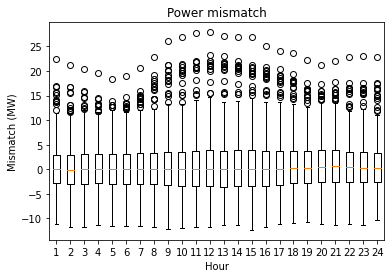

In [30]:
fig = plt.figure()
Pmis_plot = Pmis_all_hour[:, :].tolist()
plt.boxplot(Pmis_plot)
plt.title("Power mismatch")
plt.xlabel("Hour")
plt.ylabel("Mismatch (MW)")
plt.show()

In [31]:
# Read S0
file = open("Results/S0all_453","rb")
S0_all = pickle.load(file)
file.close()

S0_all

array([[2792.74314649, 2791.87355498, 2792.97860181],
       [2813.99915503, 2802.76698467, 2805.7385374 ],
       [2863.8827017 , 2848.99483728, 2852.72067893],
       [2905.89810957, 2897.28172958, 2900.44423917],
       [2949.659327  , 2948.07967751, 2949.3103936 ],
       [3033.33544344, 3032.69591188, 3033.86586676],
       [3137.92977235, 3143.44466806, 3144.52111449],
       [3252.53196522, 3248.68670903, 3256.03988697],
       [3309.73241566, 3310.95240555, 3313.68235265],
       [3383.70591913, 3389.88729611, 3389.86565761],
       [3408.81941658, 3409.04831723, 3410.28086683],
       [3448.35711028, 3461.16984962, 3463.41423089],
       [3532.51826395, 3530.21832971, 3531.55013588],
       [3625.41038914, 3622.86710612, 3624.56675501],
       [3758.16622823, 3756.86580331, 3758.47991717],
       [3813.20627568, 3812.26099132, 3813.82130939],
       [3980.671587  , 3980.52451612, 3982.03041786],
       [4138.49509848, 4145.62437467, 4145.62382977],
       [4244.27561636, 4251.

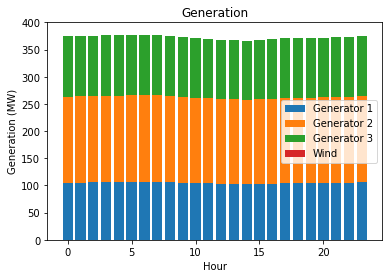

In [32]:
# Read RG up and down data
PG_all_hour = np.zeros((NG, nhours))
PG_sum_hour = np.zeros(nhours)
PW_f_hour = np.zeros(nhours)

for h in range(nhours):
    model = models[h]
    PG_all = model.PG[:]()
    PG_all = np.array(PG_all).reshape(NG)*baseMVA

    for i in range(NG):
        PG_one = PG_all[i]
        PG_all_hour[i, h] = PG_one

    PG_sum_hour[h] = np.sum(PG_all_hour[:,h])

    # Wind power forecast
    # PW_f_hour[h] = np.median(PW_data[h, :])*baseMVA

fig = plt.figure()


plt.bar(range(nhours), PG_all_hour[0], label="Generator 1")
plt.bar(range(nhours), PG_all_hour[1], bottom=PG_all_hour[0], label="Generator 2")
plt.bar(range(nhours), PG_all_hour[2], bottom=PG_all_hour[0]+PG_all_hour[1], label="Generator 3")
plt.bar(range(nhours), PW_f_hour, bottom=PG_all_hour[0]+PG_all_hour[1]+PG_all_hour[2], label="Wind")


plt.xlabel("Hour")
plt.ylabel("Generation (MW)")
plt.ylim(0, 400)
plt.title("Generation")
plt.legend()
plt.show()

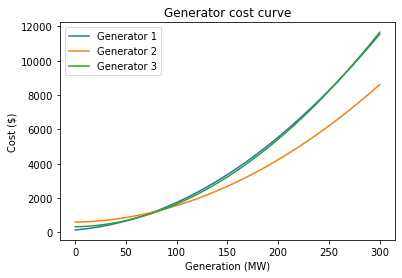

In [33]:
# Plot cost curve
x = np.linspace(0, 300, 1000)

fig = plt.figure()

for i in range(NG):
    gencost = CG0[i] + CG1[i]/baseMVA * x +  CG2[i]/baseMVA**2 * x**2
    plt.plot(x, gencost, label="Generator %d" %(i+1))

plt.legend()
plt.xlabel("Generation (MW)")
plt.ylabel("Cost ($)")
plt.title("Generator cost curve")
plt.show()

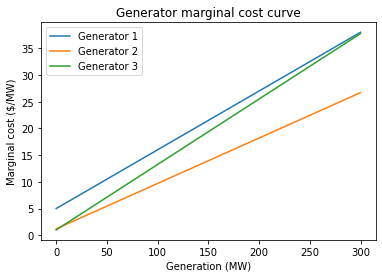

In [34]:
# Plot cost curve
x = np.linspace(0, 300, 1000)

fig = plt.figure()

for i in range(NG):
    genmc = CG1[i]/baseMVA +  CG2[i]/baseMVA**2 * x
    plt.plot(x, genmc, label="Generator %d" %(i+1))

plt.legend()
plt.xlabel("Generation (MW)")
plt.ylabel("Marginal cost ($/MW)")
plt.title("Generator marginal cost curve")
plt.show()

In [35]:
# gen_cost,gen_r_cost,load_r_cost,total_cost

gen_cost_hour = np.zeros((NG,nhours))
gen_r_cost_hour = np.zeros((NG,nhours))
load_r_cost_hour = np.zeros((NL,nhours))
total_cost_hour = np.zeros(nhours)

for h in range(nhours):
    gen_cost,gen_r_cost,load_r_cost,total_cost = cost(models[0],CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL)
    gen_cost_hour[:,h] = gen_cost
    gen_r_cost_hour[:,h] = gen_r_cost
    load_r_cost_hour[:,h] = load_r_cost
    total_cost_hour[h] = total_cost

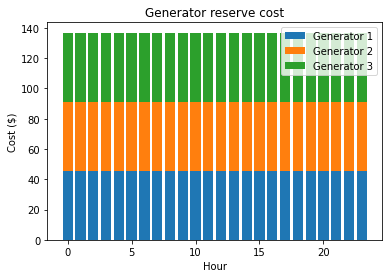

In [36]:
fig = plt.figure()

plt.bar(range(nhours), gen_r_cost_hour[0, :], label="Generator 1")
plt.bar(range(nhours), gen_r_cost_hour[1, :], bottom=gen_r_cost_hour[0, :], label="Generator 2")
plt.bar(range(nhours), gen_r_cost_hour[2, :], bottom=gen_r_cost_hour[1, :]+gen_r_cost_hour[0, :], label="Generator 3")

plt.legend()
plt.xlabel("Hour")
plt.ylabel("Cost ($)")
plt.title("Generator reserve cost")
plt.show()

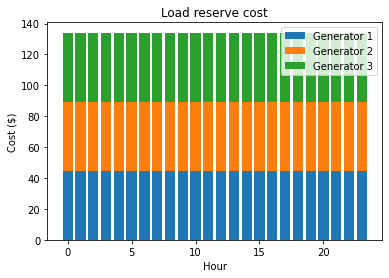

In [37]:
fig = plt.figure()

plt.bar(range(nhours), load_r_cost_hour[0, :], label="Generator 1")
plt.bar(range(nhours), load_r_cost_hour[1, :], bottom=load_r_cost_hour[0, :], label="Generator 2")
plt.bar(range(nhours), load_r_cost_hour[2, :], bottom=load_r_cost_hour[1, :]+load_r_cost_hour[0, :], label="Generator 3")

plt.legend()
plt.xlabel("Hour")
plt.ylabel("Cost ($)")
plt.title("Load reserve cost")
plt.show()